<a href="https://colab.research.google.com/github/Alexasandrovich/Data_for_ML_second/blob/master/Segm_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! git clone https://github.com/Alexasandrovich/Data_for_ML_second.git MLL
 

Cloning into 'MLL'...
remote: Enumerating objects: 11683, done.
remote: Counting objects: 100% (11683/11683), done.
remote: Compressing objects: 100% (11542/11542), done.
remote: Total 11683 (delta 129), reused 11680 (delta 129), pack-reused 0
Receiving objects: 100% (11683/11683), 84.36 MiB | 27.90 MiB/s, done.
Resolving deltas: 100% (129/129), done.
Checking out files: 100% (13226/13226), done.


In [0]:
import os
import random 
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [0]:
from tqdm import tqdm_notebook, trange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label # ???
from sklearn.model_selection import train_test_split
import keras.backend as K

Using TensorFlow backend.


In [0]:
import tensorflow as tf
import keras

In [0]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPooling2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, RemoteMonitor, ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [0]:
im_width = 128
im_height = 128 
path_train = 'MLL/train'
path_test = 'MLL/test'

In [0]:
def get_data(path, train = True):
    ids1 = iter(os.listdir(os.path.join(path, 'images/')))
    ids2 = iter(os.listdir(os.path.join(path, 'masks/')))
    X = np.zeros((4000, im_height, im_width, 1), dtype = np.float32)
    if train:
        y = np.zeros((4000, im_height, im_width, 1), dtype = np.float32)
        
    for n, id_ in enumerate(ids1):
        ids1 = iter(ids1)
        img = load_img(path + '/images/' + next(ids1))
        x_img = img_to_array(img)/255
        x_img = resize(x_img, (128, 128, 1), mode = 'constant')
        
    for n, id_ in enumerate(ids2):
        ids2 = iter(ids2)
        mask_img = load_img(path + '/masks/' + next(ids2))
        mask = img_to_array(mask_img)/255
        mask = resize(mask, (128, 128, 1), mode='constant') 
    
        X[n, ..., 0] = x_img.squeeze() / 255 # убирает одномерные оси, хз зачем это здесь, скорее всего, чтобы убрать цвет, мол серый и всё тут
        if train:
            y[n] = mask / 255
    if train: 
        return X,y
    else: 
        return X
    
       

In [0]:
X, y = get_data(path_train, True)


In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2018)

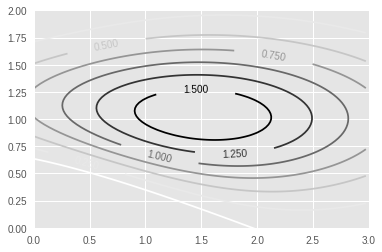

In [0]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0)
Z2 = mlab.bivariate_normal(X, Y, 1.5, 0.5, 1, 1)
# difference of Gaussians
Z = 10.0 * (Z2 - Z1)

plt.figure()
levels = np.arange(0.00, 3.00, 0.25)
CS = plt.contour(X, Y, Z, levels=levels)
plt.clabel(CS, inline=1, fontsize=10)
plt.xlim(0, 3)
plt.ylim(0, 2)
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


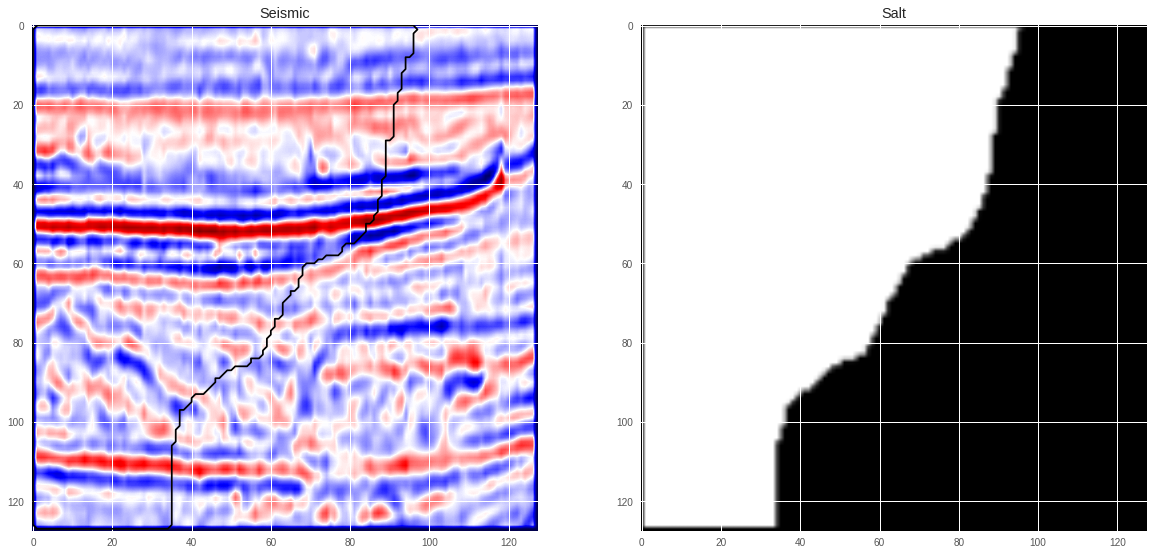

In [0]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.1])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    return x

In [0]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
# плохо работает - нестабильно
def dice_coef(y_true, y_pred, smooth=1): # шо здесь происходи
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [0]:
def focal_loss_fixed(y_true, y_pred, gamma  = 2., alpha = .25):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


In [0]:
def precision(y_true, y_pred):
     """Precision metric.
     Only computes a batch-wise average of precision.
     Computes the precision, a metric for multi-label classification of
     how many selected items are relevant.
     """
     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
     precision = true_positives / (predicted_positives + K.epsilon())
     return precision

def recall(y_true, y_pred):
     """Recall metric.
     Only computes a batch-wise average of recall.
     Computes the recall, a metric for multi-label classification of
     how many relevant items are selected.
     """
     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
     recall = true_positives / (possible_positives + K.epsilon())
     return recall

def fbeta_score(y_true, y_pred, beta=1):
     """Computes the F score.
     The F score is the weighted harmonic mean of precision and recall.
     Here it is only computed as a batch-wise average, not globally.
     This is useful for multi-label classification, where input samples can be
     classified as sets of labels. By only using accuracy (precision) a model
     would achieve a perfect score by simply assigning every class to every
     input. In order to avoid this, a metric should penalize incorrect class
     assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
     computes this, as a weighted mean of the proportion of correct class
     assignments vs. the proportion of incorrect class assignments.
     With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
     correct classes becomes more important, and with beta > 1 the metric is
     instead weighted towards penalizing incorrect class assignments.
     """
     if beta < 0:
         raise ValueError('The lowest choosable beta is zero (only precision).')
     # If there are no true positives, fix the F score at 0 like sklearn.
     if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
         return 0
     p = precision(y_true, y_pred)
     r = recall(y_true, y_pred)
     bb = beta ** 2
     fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
     return fbeta_score

def fmeasure(y_true, y_pred):
     """Computes the f-measure, the harmonic mean of precision and recall.
     Here it is only computed as a batch-wise average, not globally.
     """
     return fbeta_score(y_true, y_pred, beta=1)

In [0]:
class MixedLoss():
  def __init__(self, alpha, gamma):
    super().__init__()
    self.alpha = alpha
    self.focal = focal_loss_fixed(gamma  = 2., alpha = .25)
   
  def foward(self, y_true, y_pred):
    loss = self.alpha * self.focal(y_true, y_pred) - math.log(dice_coef_loss(y_true, y_pred))
    return loss.mean()

In [0]:
def iou_coef(y_true, y_pred, smooth = 1):
  intersection = K.sum(K.abs(y_true * y_pred), axis = -1)
  union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
  return (intersection + smooth) / (union + smooth)

def iou_coef_loss(y_true, y_pred):
  return -iou_coef(y_true, y_pred)

In [0]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss=dice_coef_loss, metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 128, 128, 16) 64          conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 128, 128, 16) 0           batch_normalization_19[0][0]     
__________________________________________________________________________________________________
conv2d_21 

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [0]:
results = model.fit(X_train, y_train, batch_size=32, epochs=20, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 3400 samples, validate on 600 samples
Epoch 1/20
3400/3400 [==============================] - 38s 11ms/step - loss: 0.9987 - acc: 0.5416 - val_loss: 0.9990 - val_acc: 0.0274

Epoch 00001: val_loss improved from inf to 0.99902, saving model to model-tgs-salt.h5
Epoch 2/20
3400/3400 [==============================] - 29s 9ms/step - loss: 0.9984 - acc: 0.5552 - val_loss: 0.9983 - val_acc: 0.5263

Epoch 00002: val_loss improved from 0.99902 to 0.99825, saving model to model-tgs-salt.h5
Epoch 3/20
3400/3400 [==============================] - 29s 8ms/step - loss: 0.9982 - acc: 0.5811 - val_loss: 0.9982 - val_acc: 0.7936

Epoch 00003: val_loss improved from 0.99825 to 0.99816, saving model to model-tgs-salt.h5
Epoch 4/20
3400/3400 [==============================] - 29s 8ms/step - loss: 0.9981 - acc: 0.6306 - val_loss: 0.9981 - val_acc: 0.5448

Epoch 00004: val_loss improved from 0.99816 to 0.99809, saving model to model-tgs-salt.h5
Epoch 5/20
3400/3400 [==============================

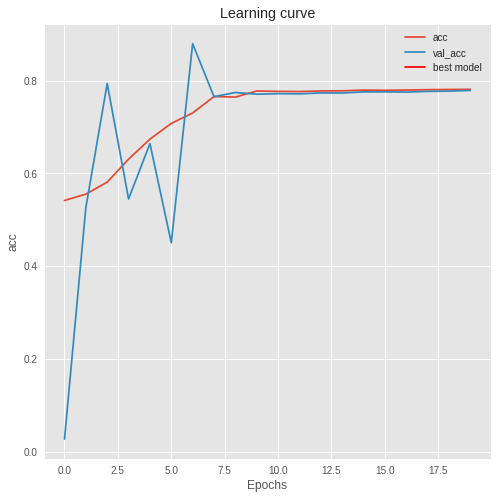

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["acc"], label="acc")
plt.plot(results.history["val_acc"], label="val_acc")
plt.plot( np.argmin(results.history["val_acc"]), np.min(results.history["val_acc"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.legend();

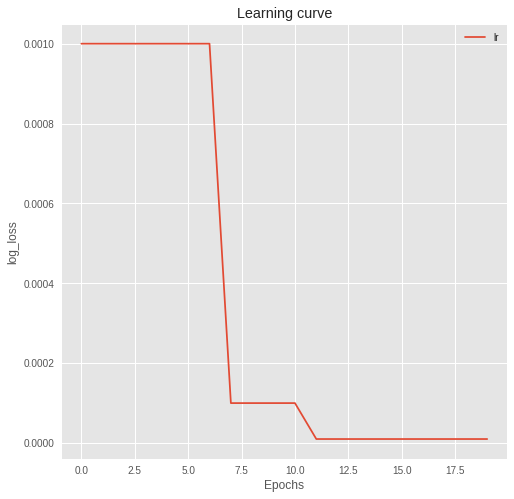

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["lr"], label="lr")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

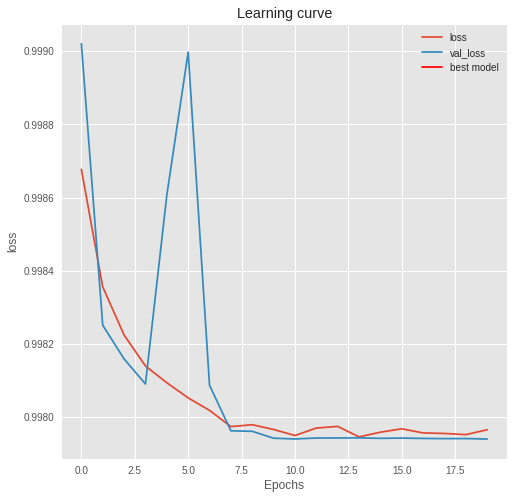

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

In [0]:
model.load_weights('model-segm.h5')

OSError: ignored

In [0]:
model.evaluate(X_valid, y_valid, verbose = 1)

600/600 [==============================] - 1s 2ms/step


[0.9979399116834005, 0.778719482421875]

In [0]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

600/600 [==============================] - 1s 2ms/step


In [0]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

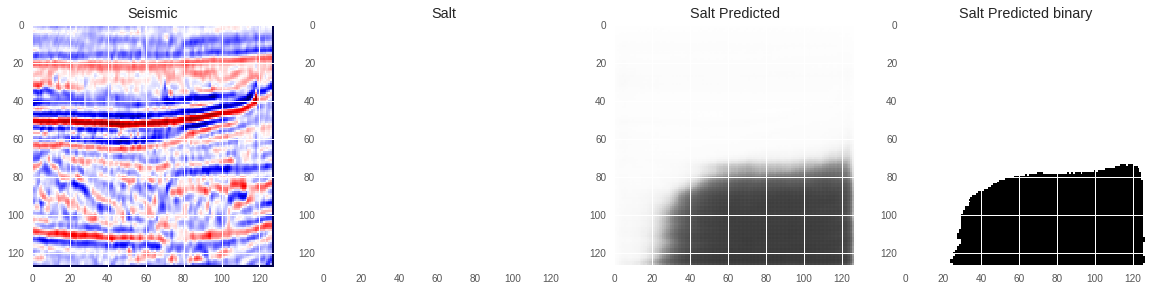

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix = 14)

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


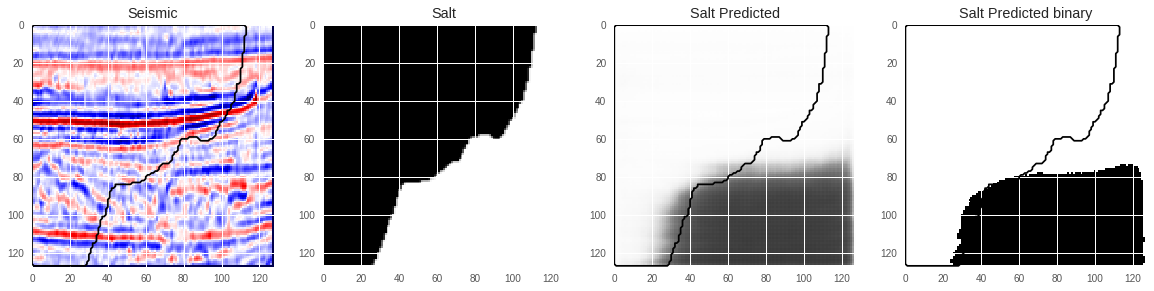

In [0]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)